By. __Muhammad Nurhakim b. Mohamed Bazet__

Main Question/Problem Statements:

Justify whether it is safer to take the aircraft nowadays ?

In this analysis we will try to make it simple and clean so that it can be easily understandable. For this problem I we will approach it in 3 steps.

1. __Preprocessing__ : Clean our dataset and make some feature engineering to our features to make it useful for our analysis and predictions later on.

2. __Exploratory Data Analysis (EDA)__: By using our clean dataset, we will make some visualization or graph to see how our data is being distributed and see the correlation between the feautres. In here we will gain some insight whether or not we want to include our some of the our features for predictions.

3. __Predictions__ : The last is where we will try to justify our main question whether is it safer to take the aircraft nowadays given a certain situation. 

### Probability of Survivor
We calculate the probability of survivor aboard the plane by this formula:

$$ P_{Survived}(X) = \frac{Aboard -Fatalities}{Aboard} $$

where X is our input features.

### Label Definition

* Date: Date Crash
* Time: Time Crash
* Operator: Pilot/Airlines
* Flight #: Flight Number
* Route: Route taken by the flight
* Type: Aeroplane type
* Registration: Registration Number 
* cn / ln: Construction or serial number / Line or fuselage number
* Aboard: Number of people aboard in the planes
* Fatalities: Number of people dies during the crashes
* Ground: Total killed on the ground
* Summary: Summary of the crashes

In [1]:
%matplotlib inline
import numpy as np #matrix multiplication 
import matplotlib.pyplot as plt # plot
import pandas as pd # dataframe
from datetime import datetime as dt # datetime format
import re #regular expression for string
from tqdm import tqdm # Fancy bar progress
from collections import Counter # Count element

In [2]:
# Read csv file
df = pd.read_csv('../Airplane_Crashes_and_Fatalities_Since_1908.csv')

In [3]:
# General info regarding our datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
Date            5268 non-null object
Time            3049 non-null object
Location        5248 non-null object
Operator        5250 non-null object
Flight #        1069 non-null object
Route           3562 non-null object
Type            5241 non-null object
Registration    4933 non-null object
cn/In           4040 non-null object
Aboard          5246 non-null float64
Fatalities      5256 non-null float64
Ground          5246 non-null float64
Summary         4878 non-null object
dtypes: float64(3), object(10)
memory usage: 535.1+ KB


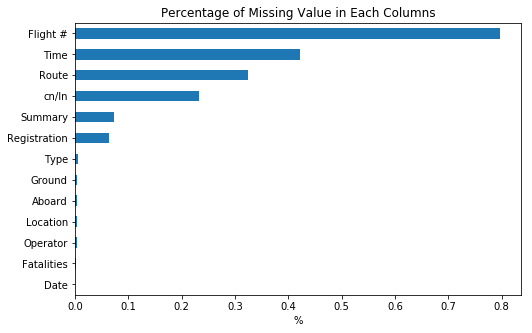

In [4]:
# Nan value in each columns
fig, ax = plt.subplots(figsize=(8,5))
(df.isnull().sum()/len(df)).sort_values(ascending=True).plot(kind='barh',ax=ax)
plt.title('Percentage of Missing Value in Each Columns')
plt.xlabel('%')

As we can see here Flight number has the most Null value with almost 80%. We will drop this columns because it contains too many NaN value. According to wikipedia also, [Flight Number](https://en.wikipedia.org/wiki/Flight_number) is just a combination of date and the airlines name. So we will assume that the flight number is not necessary for our analysis since there are already features with time, dates of crashes, opearator, and type of airplane. This features might be redundant and might affect our analysis later on.

In [5]:
df.drop('Flight #',axis=1,inplace=True)

In [6]:
# Let create the probability column for survivor

df['Survive_Prob'] = np.nan
df['Survive_Prob'] = (df.Aboard - df.Fatalities)/df.Aboard

In [7]:
# Change Date column formats
df.Date = pd.to_datetime(df.Date)

In [8]:
# Extracting the hours only
df['Hours'] = np.nan
for row in tqdm(range(df.shape[0])):
    try:
        df.iloc[row,-1] = pd.to_datetime(df.iloc[row,1]).hour
    except:
        pass

100%|█████████████████████████████████████| 5268/5268 [00:10<00:00, 479.01it/s]


One of the key features here of the survivor will be time whether it is in the morning, afternoon, evening, or night. So in here we will only extract the hours of the time rather than include it with the minutes.

#### Extracting the location of airplane crash (Label : State_Countries) 

Instead of focusing on the specific location, we will group it by States or Countries depends on the data given. As example for our first entry of data frame the location of the crash is Fort Myer, Virgina. By using regular expression Our new label *States* will only take the label Virginia. 

In [9]:
# Extract all keyword after , ie Fort Myer, Virginia -> Virginia
def get_states(address):
    if ',' in address:
        regex = re.compile(r'\,(.*)')
        state = re.search(regex,address).group(0)
        state = state.replace(',','')
        return state.strip()
    else:
        return address

In [10]:
df['State_Countries'] = np.nan
for index,state in tqdm(enumerate(df.Location)):
    try:
        df.loc[df.Location.index[index],'State_Countries'] = get_states(state)
    except:
        pass

5268it [00:08, 621.08it/s]


In [12]:
df.head(1)

,Date,Time,Location,Operator,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Survive_Prob,Hours,State_Countries
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",0.5,17.0,Virginia


#### (Label : Source and Destination)

We can get the source and destination of the flight from the Route columns.  

In [13]:
def get_source_destination(routes):
    
    if '-' in routes:
        regex = re.compile(r'(.*)\-')
        state_source = re.search(regex,routes).group(0)
        state_source = state_source.replace('-','')
        state_source = state_source.strip()
        
        regex = re.compile(r'\-(.*)')
        state_dest = re.search(regex,routes).group(0)
        state_dest = state_dest.replace('-','')
        state_dest = state_dest.strip()
        
        return state_source, state_dest
    
    else:
        
        return routes, routes

In [14]:
# Get the source and destination from Route
df['Source'] = np.nan
df['Destination'] = np.nan

In [15]:
for index,route in tqdm(enumerate(df.Route)):
    
    try:
        if '-' in route:
            src, dest = get_source_destination(route)
            df.loc[df.Route.index[index],'Source'] = src
            df.loc[df.Route.index[index],'Destination'] = dest
        else:
            df.loc[df.Route.index[index],'Source'] = route
            df.loc[df.Route.index[index],'Destination'] = route
            
    except:
        pass

5268it [00:12, 412.06it/s]


In [16]:
df.iloc[-3,:]

Date                                             2009-06-01 00:00:00
Time                                                           00:15
Location           AtlantiOcean, 570 miles northeast of Natal, Br...
Operator                                                  Air France
Route                                         Rio de Janeiro - Paris
Type                                                 Airbus A330-203
Registration                                                  F-GZCP
cn/In                                                            660
Aboard                                                           228
Fatalities                                                       228
Ground                                                             0
Summary            The Airbus went missing over the AtlantiOcean ...
Survive_Prob                                                       0
Hours                                                              0
State_Countries                  5

As we can see in the above dataframe we managed to grab the location of the source and destination just based on the Route data. There are some problem with this if there is no "-" in the string. In that case, the value of the source and destination will be the same as the Route.

#### (Label : Plane_Name)

Plane Type: We will take the first letter of each keyword in type. i.e __Zeppelin L-1 (airship)__ we will extract the word __Zeppelin__ only.

In [17]:
def get_type(planetype):
    # Get the first word 
    regex = re.compile(r'^([\w]+)')
    state_source = re.search(regex,planetype).group(0)
    
    return state_source
    

In [18]:
df['Plane_Name'] = np.nan

In [19]:
# Capatalize first word
df.Type = df.Type.str.capitalize()

In [20]:
for index,planeType in tqdm(enumerate(df.Type)):
    try:
        df.loc[df.Type.index[index],'Plane_Name'] = get_type(planeType)
    except:
        pass
    

5268it [00:09, 566.50it/s]


#### Plane Type (Label : Passenger_Military)

Here we will add an extra labels to determine whether the type of airplanee is a fighter/warplane or it is a passenger airplanes. We determine it by the name of the Operator.

The label id for the *Passenger_Military* will be Passenger:__1__ and Warplane/Fighter:__0__

In [21]:
war_type = ['Military','Army','Navy','Royal']

In [22]:
# Classify our plane to 2 type of plane based on Operator
# Passenger = 1 , Military = 0
df['Passenger_Military'] = np.nan

In [23]:
for index,operator in tqdm(enumerate(df.Operator)):
    try:
        if any(word in operator for word in war_type) == True:          
            df.loc[df.Operator.index[index],'Passenger_Military'] = 0
        elif any(word in operator for word in war_type) == False:
            df.loc[df.Operator.index[index],'Passenger_Military'] = 1     
    except:
        pass
    

5268it [00:06, 821.23it/s]


In [24]:
df.set_index('Date',inplace=True)

##  NLTK Summary

Based on the summary given we will try to see the cause of the crashes by using NLTK

In [25]:
# Natural Language Tool Kits (NLTK)
from nltk.corpus import stopwords # Stopword
from nltk.tokenize import word_tokenize #Tokenize our word
from nltk.probability import FreqDist # Count Words


In [26]:
# Summary NLTK
stop_words = set(stopwords.words('english'))
stop_words.update([',','.','!','The',])

In [27]:
token_df = pd.Series(np.nan,index=df.index)

In [28]:
total_filter_sentence = []

for index,sentence in tqdm(enumerate(df.Summary)):
    token_summary = []
    try:
        word_tokens = word_tokenize(sentence)
        for w in word_tokens:
            if w not in stop_words:
                total_filter_sentence.append(w.lower())
                token_summary.append(w.lower())
        token_df.iloc[index] = token_summary
        
    except:
        pass

5268it [00:10, 499.67it/s]


In [29]:
df.to_pickle('../Aircrashesh-cleaned.pkl')

In [30]:
token_df.to_pickle('../Summary_token_word.pkl')